In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE


In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0
y_train_flat = y_train.flatten()
y_test_flat  = y_test.flatten()


In [ ]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(32, 32, 3)),
            layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
            layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2)
        ])
        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
            layers.Conv2D(3, kernel_size=3, activation='sigmoid', padding='same')
        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Denoise()
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "denoise_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 8, 8, 8)        │         1,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,608 (6.28 KB)

 Trainable params: 1,608 (6.28 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(autoencoder.encoder(x_test)).numpy()

In [ ]:
history = autoencoder.fit(
    x_train, x_train,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(x_test, x_test)
)


Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 60s 148ms/step - loss: 0.0336 - val_loss: 0.0074
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 81s 146ms/step - loss: 0.0061 - val_loss: 0.0051
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 147ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 60s 153ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 65s 166ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 75s 149ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 59s 152ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 153ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 86s 163ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 61s 156ms/step - loss: 0.0026 - val_loss: 0.0025


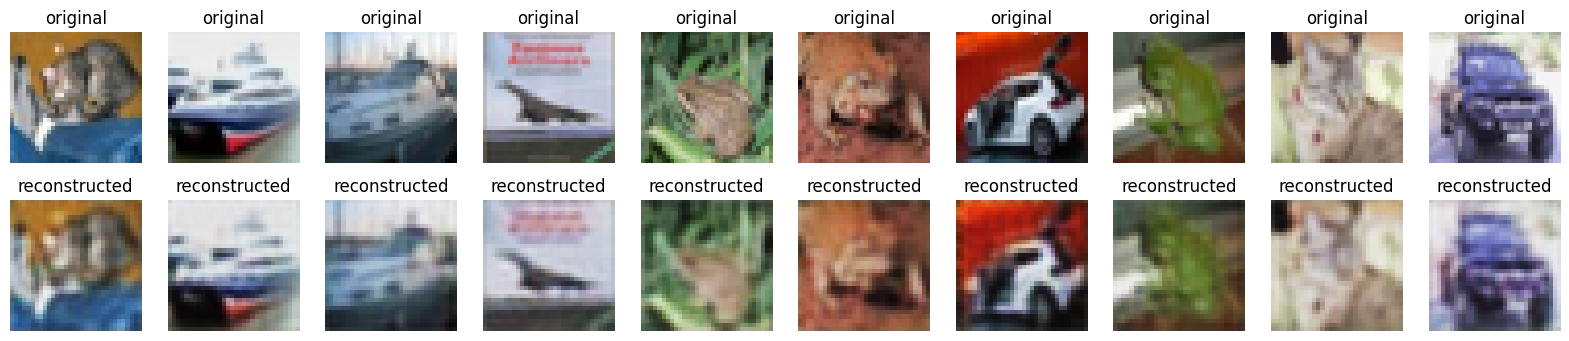

In [ ]:
decoded_imgs = autoencoder.decoder(autoencoder.encoder(x_test)).numpy()
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])  # already in [0,1]
    plt.title("original")
    plt.axis('off')

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])  # already in [0,1]
    plt.title("reconstructed")
    plt.axis('off')
plt.show()


In [ ]:
# latent_features = autoencoder.encoder(x_test).numpy()
# print("Bottleneck latent shape:", latent_features.shape)

bottleneck_features = autoencoder.encoder(x_train)

num_samples = bottleneck_features.shape[0]
latent_flattened = bottleneck_features.numpy().reshape((num_samples, -1))


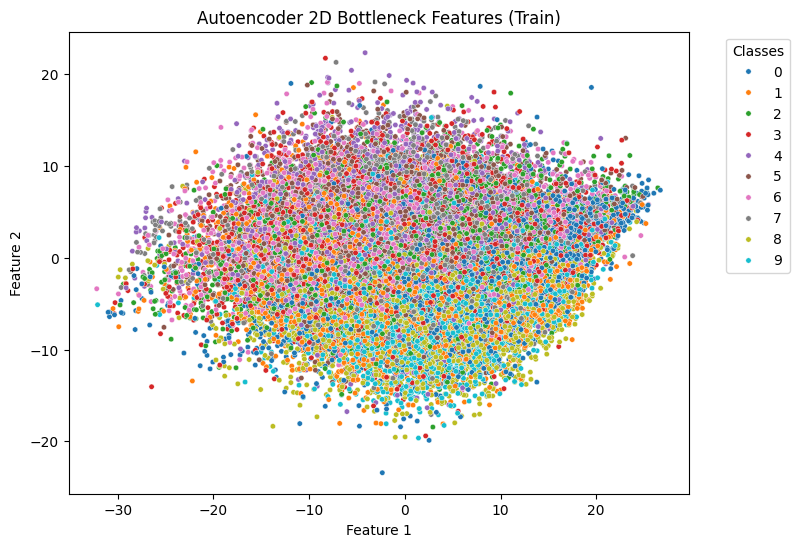

In [ ]:
# Fit PCA and transform the data
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_flattened)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=y_train_flat, palette='tab10', s=15, legend='full')
plt.title("Autoencoder 2D Bottleneck Features (Train)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Classes")
plt.show()

In [ ]:
# VGG16
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3), pooling='avg')
vgg_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x_test_resized = tf.image.resize(x_test, (32, 32))
x_test_preprocessed = preprocess_input(x_test_resized * 255.0)

vgg_features = vgg_model.predict(x_test_preprocessed, batch_size=128)
print("VGG16 features on original images shape:", vgg_features.shape)


79/79 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step
VGG16 features on original images shape: (10000, 512)


In [ ]:
x_train_resized = tf.image.resize(x_train, (32, 32))
x_train_preprocessed = preprocess_input(x_train_resized * 255.0)

vgg_features_train = vgg_model.predict(x_train_preprocessed, batch_size=128)
print("VGG16 features on original images shape:", vgg_features_train.shape)

391/391 ━━━━━━━━━━━━━━━━━━━━ 539s 1s/step
VGG16 features on original images shape: (50000, 512)


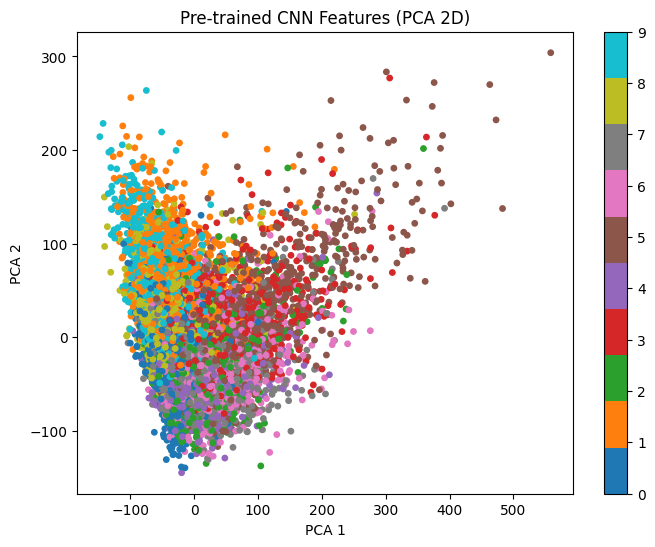

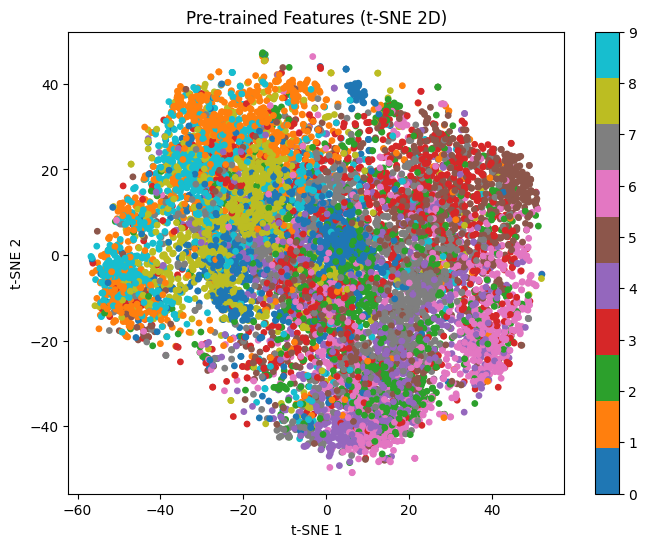

In [ ]:
# PCA
pca = PCA(n_components=2)
vgg_pca_2d = pca.fit_transform(vgg_features)

# t-SNE
tsne = TSNE(n_components=2, init='pca', random_state=42, perplexity=50, learning_rate=200, max_iter=1000)
vgg_tsne_2d = tsne.fit_transform(vgg_features)


# y_plot = y_train_flat[:vgg_features.shape[0]]  # ensure same length
plt.figure(figsize=(8,6))

plt.scatter(vgg_pca_2d[:,0], vgg_pca_2d[:,1], c=y_test_flat, s=15, cmap='tab10')
plt.colorbar(ticks=range(10))
plt.title("Pre-trained CNN Features (PCA 2D)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")

plt.figure(figsize=(8,6))
plt.scatter(vgg_tsne_2d[:,0], vgg_tsne_2d[:,1], c=y_test_flat, s=15, cmap='tab10')
plt.colorbar(ticks=range(10))
plt.title("Pre-trained Features (t-SNE 2D)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

plt.show()



In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32') / 255.0

# Removed the line that adds an extra dimension
# x_train = x_train[..., tf.newaxis]
# x_test = x_test[..., tf.newaxis]

print("x_train:", x_train.shape, "x_test:", x_test.shape)

x_train: (50000, 32, 32, 3) x_test: (10000, 32, 32, 3)


# Application to image denoising

In [ ]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

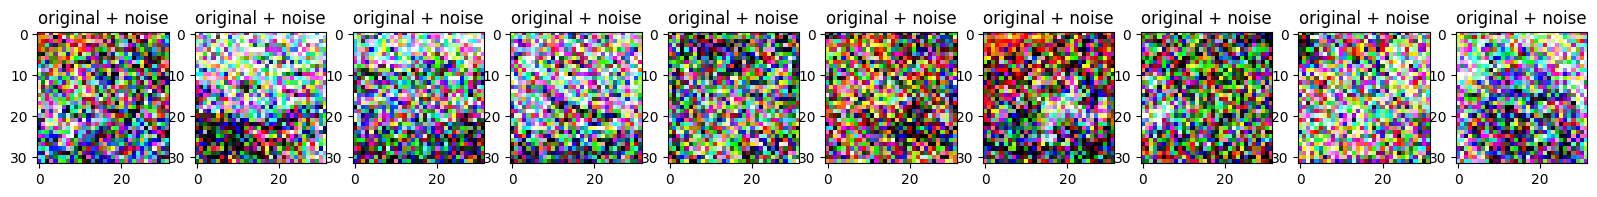

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

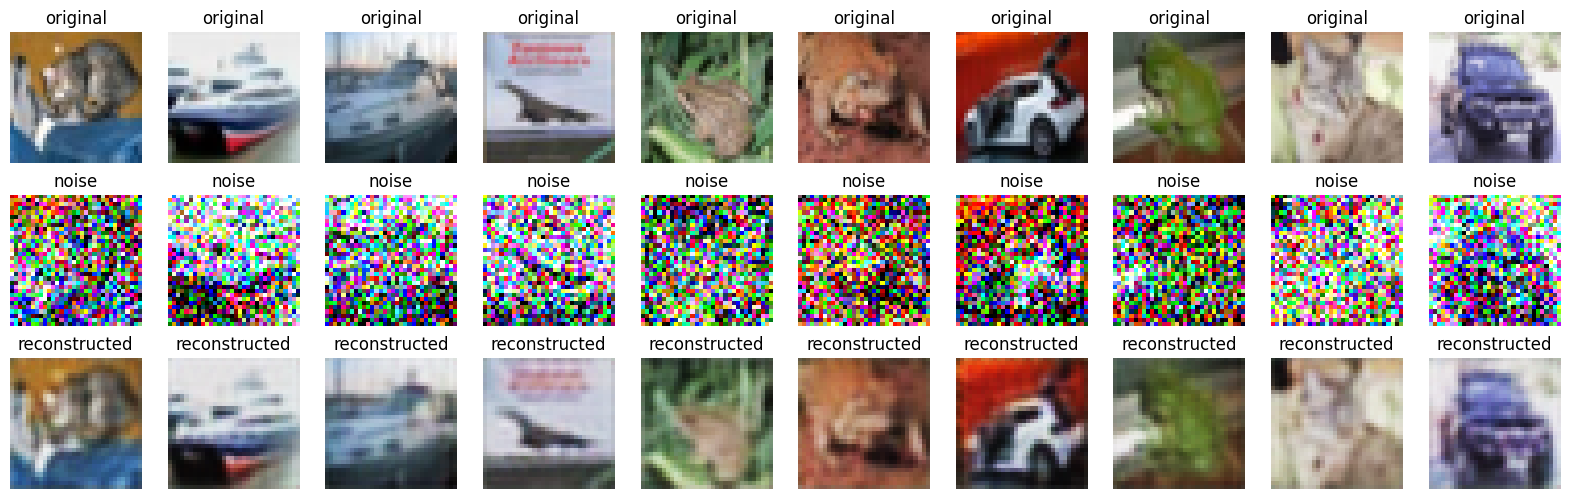

In [ ]:
n = 10
plt.figure(figsize=(20, 6))

for i in range(n):
    # original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])  # RGB
    plt.title("original")
    plt.axis('off')

    # noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.title("noise")
    plt.axis('off')

    # reconstructed
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow((decoded_imgs[i] * 255).astype(np.uint8))
    plt.title("reconstructed")
    plt.axis('off')

plt.show()
